## Imports and dataset loading

In [1]:
import sys
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_validate
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, balanced_accuracy_score
import tensorflow as tf
import matplotlib as plt
from tensorflow import keras

In [2]:
DATASET_PATH: str = "../../dataset/"

In [3]:
df = pd.read_csv('../../dataset/trainU.csv', sep=',', index_col=0)

## Train-val-test split

In [4]:
data_cols = [col_name for col_name in df.columns if col_name != 'DISEASE']

In [5]:
big_train_x, test_x, big_train_y, test_y = train_test_split(df[data_cols], df['DISEASE'], test_size=.25, stratify=df['DISEASE'])

In [6]:
temp_df = df.drop(big_train_x.index)
train_df = df.drop(temp_df.index)
train_df.shape

(224, 4421)

In [7]:
train_x, val_x, train_y, val_y = train_test_split(big_train_x, train_df['DISEASE'], test_size=.25, stratify=train_df['DISEASE'])

### Shapes

Now we have the following sets 

In [8]:
print("Train: ", train_x.shape, train_y.shape, "\nVal: ", val_x.shape, val_y.shape, "\nTest: ", test_x.shape, test_y.shape, )

Train:  (168, 4420) (168,) 
Val:  (56, 4420) (56,) 
Test:  (75, 4420) (75,)


In [9]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()

In [10]:
encoder = encoder.fit(np.array(df['DISEASE']).reshape(-1, 1))

In [11]:
train_y_o = encoder.transform(np.asarray(train_y).reshape(-1,1))
val_y_o   = encoder.transform(np.asarray(val_y).reshape(-1,1))
test_y_o  = encoder.transform(np.asarray(test_y).reshape(-1,1))

In [12]:
print("Train: ", train_x.shape, train_y_o.shape, "\nVal: ", val_x.shape, val_y_o.shape, "\nTest: ", test_x.shape, test_y_o.shape, )

Train:  (168, 4420) (168, 5) 
Val:  (56, 4420) (56, 5) 
Test:  (75, 4420) (75, 5)


## Build the model

In [13]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import SGD, Ftrl

In [14]:
model = Sequential()
model.add(Dense(10, activation ='relu', input_dim = train_x.shape[1]))
model.add(Dropout(0.4))
#model.add(Dense(8, activation ='relu'))
#model.add(Dropout(0.4))
model.add(Dense(train_y_o.shape[1], activation='softmax'))

2022-06-19 11:28:00.285736: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                44210     
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 55        
                                                                 
Total params: 44,265
Trainable params: 44,265
Non-trainable params: 0
_________________________________________________________________


In [16]:
sgd = SGD(learning_rate=0.0001, decay=1e-6, momentum=0.9, nesterov=True)

In [17]:
ftrl = Ftrl(learning_rate=0.001)

In [18]:
model.compile(loss='categorical_crossentropy',
             optimizer=sgd,
             metrics=['accuracy'])

In [19]:
#scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch/20))

In [20]:
#train_x_tensor = np.reshape(np.asarray(train_x), (train_x.shape[0], 1, train_x.shape[1]))

In [21]:
#history = model.fit(np.asarray(train_x), train_y_o.toarray(), epochs=100, callbacks=[scheduler])
history = model.fit(np.asarray(train_x), train_y_o.toarray(),
                    epochs=100,
                    validation_data=(np.asarray(val_x),val_y_o.toarray()))

Epoch 1/100
6/6 [==============================] - 1s 46ms/step - loss: 2.1373 - accuracy: 0.1071 - val_loss: 1.8579 - val_accuracy: 0.1071
Epoch 2/100
6/6 [==============================] - 0s 8ms/step - loss: 1.7437 - accuracy: 0.1250 - val_loss: 1.6428 - val_accuracy: 0.1429
Epoch 3/100
6/6 [==============================] - 0s 9ms/step - loss: 1.6274 - accuracy: 0.2560 - val_loss: 1.6108 - val_accuracy: 0.1786
Epoch 4/100
6/6 [==============================] - 0s 8ms/step - loss: 1.6141 - accuracy: 0.2679 - val_loss: 1.6041 - val_accuracy: 0.2679
Epoch 5/100
6/6 [==============================] - 0s 8ms/step - loss: 1.6057 - accuracy: 0.3095 - val_loss: 1.6013 - val_accuracy: 0.3036
Epoch 6/100
6/6 [==============================] - 0s 8ms/step - loss: 1.5958 - accuracy: 0.3988 - val_loss: 1.5982 - val_accuracy: 0.3214
Epoch 7/100
6/6 [==============================] - 0s 8ms/step - loss: 1.5928 - accuracy: 0.3690 - val_loss: 1.5957 - val_accuracy: 0.3214
Epoch 8/100
6/6 [=========

In [22]:
score = history.model.evaluate(train_x, train_y_o.toarray())

6/6 [==============================] - 0s 3ms/step - loss: 1.3867 - accuracy: 0.5952


<AxesSubplot:title={'center':'Model Loss and Accuracy Curve'}>

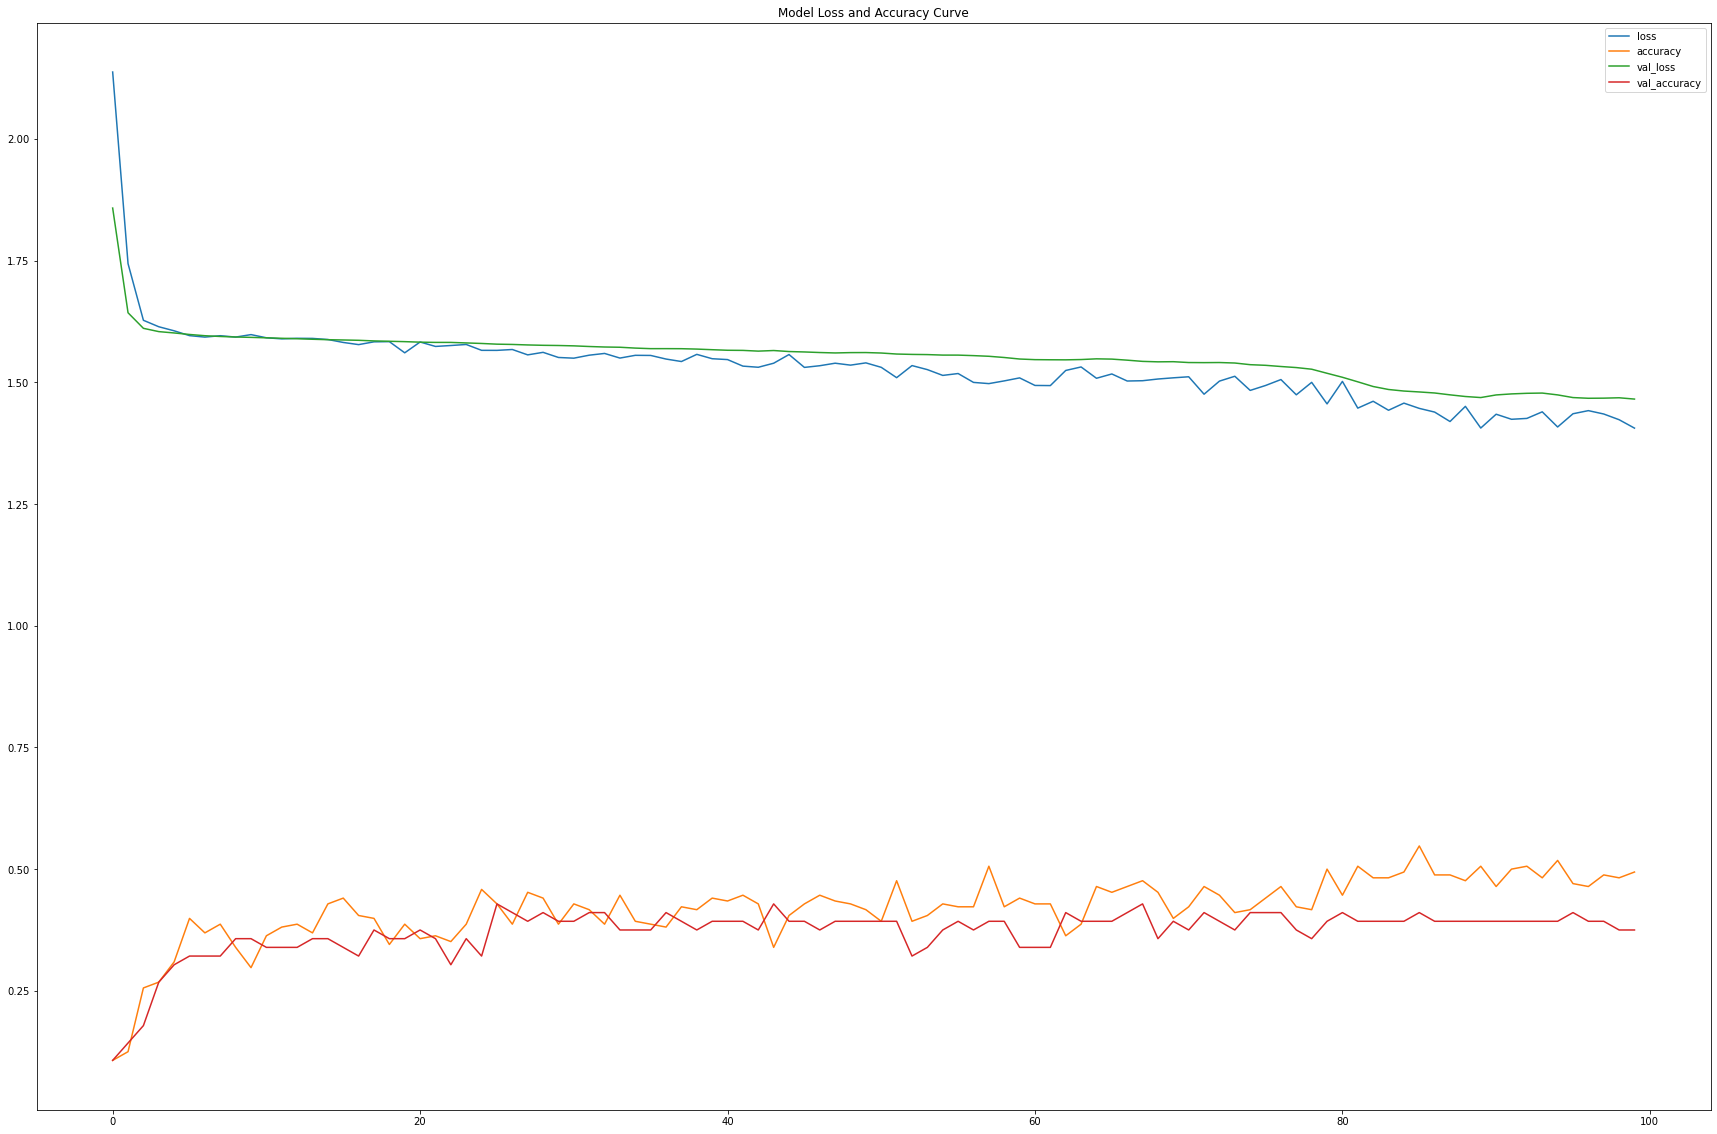

In [23]:
results = pd.DataFrame(history.history)
results.plot(figsize=(30,20), title="Model Loss and Accuracy Curve")

#results[["loss","accuracy"]].plot(figsize=(30,20), title="Model Loss and Accuracy Curve")
#plt.title("Model Loss Curve")

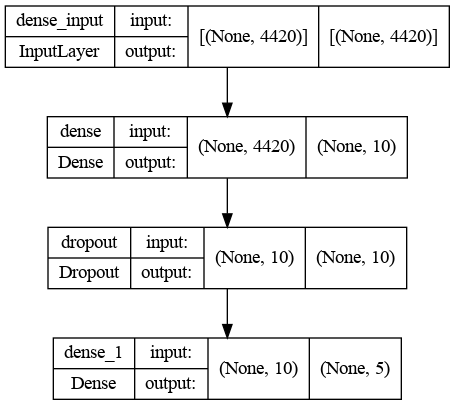

In [24]:
from tensorflow.keras.utils import plot_model

plot_model(model,show_shapes=True)

In [25]:
train_predictions = model.predict(train_x)

In [26]:
train_predictions2 = train_predictions

In [27]:
for row in range(train_predictions2.shape[0]):
#    print(max(train_predictions2[row]))
    a,b,c,d,e = train_predictions2[row]
    if a==max(a,b,c,d,e):
        train_predictions2[row][0] = 1
        train_predictions2[row][1:5] = 0
    elif b==max(a,b,c,d,e):
        train_predictions2[row][1] = 1
        train_predictions2[row][0] = 0
        train_predictions2[row][2:5] = 0
    elif c==max(a,b,c,d,e):
        train_predictions2[row][2] = 1
        train_predictions2[row][0:2] = 0
        train_predictions2[row][3:5] = 0
    elif d==max(a,b,c,d,e):
        train_predictions2[row][3] = 1
        train_predictions2[row][0:3] = 0
        train_predictions2[row][4] = 0
    else:
        train_predictions2[row][4] = 1
        train_predictions2[row][0:4] = 0

In [28]:
from sklearn.metrics import confusion_matrix

confusion_matrix(encoder.inverse_transform(train_y_o.toarray()), encoder.inverse_transform(train_predictions2))

array([[32, 20,  2,  0,  0],
       [ 6, 68,  0,  0,  0],
       [ 4,  8,  0,  0,  0],
       [ 6,  6,  0,  0,  0],
       [ 5, 11,  0,  0,  0]])

### VAL

In [29]:
val_predictions = model.predict(val_x)

In [30]:
for row in range(val_predictions.shape[0]):
#    print(max(train_predictions2[row]))
    a,b,c,d,e = val_predictions[row]
    if a==max(a,b,c,d,e):
        val_predictions[row][0] = 1
        val_predictions[row][1:5] = 0
    elif b==max(a,b,c,d,e):
        val_predictions[row][1] = 1
        val_predictions[row][0] = 0
        val_predictions[row][2:5] = 0
    elif c==max(a,b,c,d,e):
        val_predictions[row][2] = 1
        val_predictions[row][0:2] = 0
        val_predictions[row][3:5] = 0
    elif d==max(a,b,c,d,e):
        val_predictions[row][3] = 1
        val_predictions[row][0:3] = 0
        val_predictions[row][4] = 0
    else:
        val_predictions[row][4] = 1
        val_predictions[row][0:4] = 0

In [31]:
confusion_matrix(encoder.inverse_transform(val_y_o.toarray()), encoder.inverse_transform(val_predictions))

array([[ 7, 11,  0,  0,  0],
       [11, 14,  0,  0,  0],
       [ 0,  4,  0,  0,  0],
       [ 1,  3,  0,  0,  0],
       [ 1,  4,  0,  0,  0]])

In [32]:
#val_results = pd.DataFrame(history.history)
#val_results[["val_loss","val_accuracy"]].plot(figsize=(30,20), title="Model VAL_Loss and VAL_Accuracy Curve")

In [33]:
df['DISEASE'].value_counts()

DIABETE    132
A1A         96
NALD        28
GS          22
MCM         21
Name: DISEASE, dtype: int64

In [34]:
train_y_o

<168x5 sparse matrix of type '<class 'numpy.float64'>'
	with 168 stored elements in Compressed Sparse Row format>

## Oversampling

In [35]:
from imblearn.over_sampling import SMOTE

In [36]:
strategy = {0:74, 1:74, 2:74, 3:74, 4:74}
oversample = SMOTE(sampling_strategy=strategy)
temp1,temp2 = oversample.fit_resample(train_x, train_y_o.toarray())

In [37]:
model2 = Sequential()
model2.add(Dense(14, activation ='relu', input_dim = temp1.shape[1]))
model2.add(Dropout(0.4))
#model.add(Dense(8, activation ='relu'))
#model.add(Dropout(0.4))
model2.add(Dense(train_y_o.shape[1], activation='softmax'))

In [38]:
model2.compile(loss='categorical_crossentropy',
             optimizer=sgd,
             metrics=['accuracy'])

In [39]:
history2 = model2.fit(np.asarray(temp1), temp2,
                    epochs=200,
                    validation_data=(np.asarray(val_x),val_y_o.toarray()))

Epoch 1/200
12/12 [==============================] - 1s 20ms/step - loss: 1.7157 - accuracy: 0.1838 - val_loss: 1.6077 - val_accuracy: 0.2500
Epoch 2/200
12/12 [==============================] - 0s 6ms/step - loss: 1.6048 - accuracy: 0.2270 - val_loss: 1.6075 - val_accuracy: 0.2321
Epoch 3/200
12/12 [==============================] - 0s 6ms/step - loss: 1.5921 - accuracy: 0.2378 - val_loss: 1.6266 - val_accuracy: 0.1964
Epoch 4/200
12/12 [==============================] - 0s 6ms/step - loss: 1.5991 - accuracy: 0.2595 - val_loss: 1.6317 - val_accuracy: 0.1786
Epoch 5/200
12/12 [==============================] - 0s 6ms/step - loss: 1.6032 - accuracy: 0.2297 - val_loss: 1.6421 - val_accuracy: 0.1607
Epoch 6/200
12/12 [==============================] - 0s 6ms/step - loss: 1.5900 - accuracy: 0.2838 - val_loss: 1.6481 - val_accuracy: 0.1429
Epoch 7/200
12/12 [==============================] - 0s 6ms/step - loss: 1.5820 - accuracy: 0.2351 - val_loss: 1.6506 - val_accuracy: 0.1250
Epoch 8/200


Epoch 59/200
12/12 [==============================] - 0s 5ms/step - loss: 1.2240 - accuracy: 0.5703 - val_loss: 1.6147 - val_accuracy: 0.1964
Epoch 60/200
12/12 [==============================] - 0s 5ms/step - loss: 1.2742 - accuracy: 0.5162 - val_loss: 1.6206 - val_accuracy: 0.1964
Epoch 61/200
12/12 [==============================] - 0s 5ms/step - loss: 1.2604 - accuracy: 0.5351 - val_loss: 1.5930 - val_accuracy: 0.2143
Epoch 62/200
12/12 [==============================] - 0s 5ms/step - loss: 1.2306 - accuracy: 0.5432 - val_loss: 1.6281 - val_accuracy: 0.1964
Epoch 63/200
12/12 [==============================] - 0s 5ms/step - loss: 1.2316 - accuracy: 0.5757 - val_loss: 1.6318 - val_accuracy: 0.1964
Epoch 64/200
12/12 [==============================] - 0s 6ms/step - loss: 1.2353 - accuracy: 0.5135 - val_loss: 1.6223 - val_accuracy: 0.1964
Epoch 65/200
12/12 [==============================] - 0s 5ms/step - loss: 1.2257 - accuracy: 0.5541 - val_loss: 1.6153 - val_accuracy: 0.1964
Epoch 

12/12 [==============================] - 0s 5ms/step - loss: 0.8801 - accuracy: 0.7081 - val_loss: 1.6021 - val_accuracy: 0.2500
Epoch 174/200
12/12 [==============================] - 0s 5ms/step - loss: 0.8899 - accuracy: 0.6892 - val_loss: 1.6116 - val_accuracy: 0.2143
Epoch 175/200
12/12 [==============================] - 0s 5ms/step - loss: 0.8802 - accuracy: 0.6730 - val_loss: 1.6063 - val_accuracy: 0.2143
Epoch 176/200
12/12 [==============================] - 0s 5ms/step - loss: 0.8700 - accuracy: 0.7000 - val_loss: 1.6065 - val_accuracy: 0.2500
Epoch 177/200
12/12 [==============================] - 0s 5ms/step - loss: 0.8351 - accuracy: 0.7135 - val_loss: 1.5956 - val_accuracy: 0.2321
Epoch 178/200
12/12 [==============================] - 0s 5ms/step - loss: 0.8504 - accuracy: 0.7351 - val_loss: 1.6099 - val_accuracy: 0.2321
Epoch 179/200
12/12 [==============================] - 0s 5ms/step - loss: 0.8300 - accuracy: 0.7270 - val_loss: 1.6039 - val_accuracy: 0.2321
Epoch 180/200

In [40]:
results2 = pd.DataFrame(history2.history)


<AxesSubplot:title={'center':'Model2 Loss and Accuracy Curve'}>

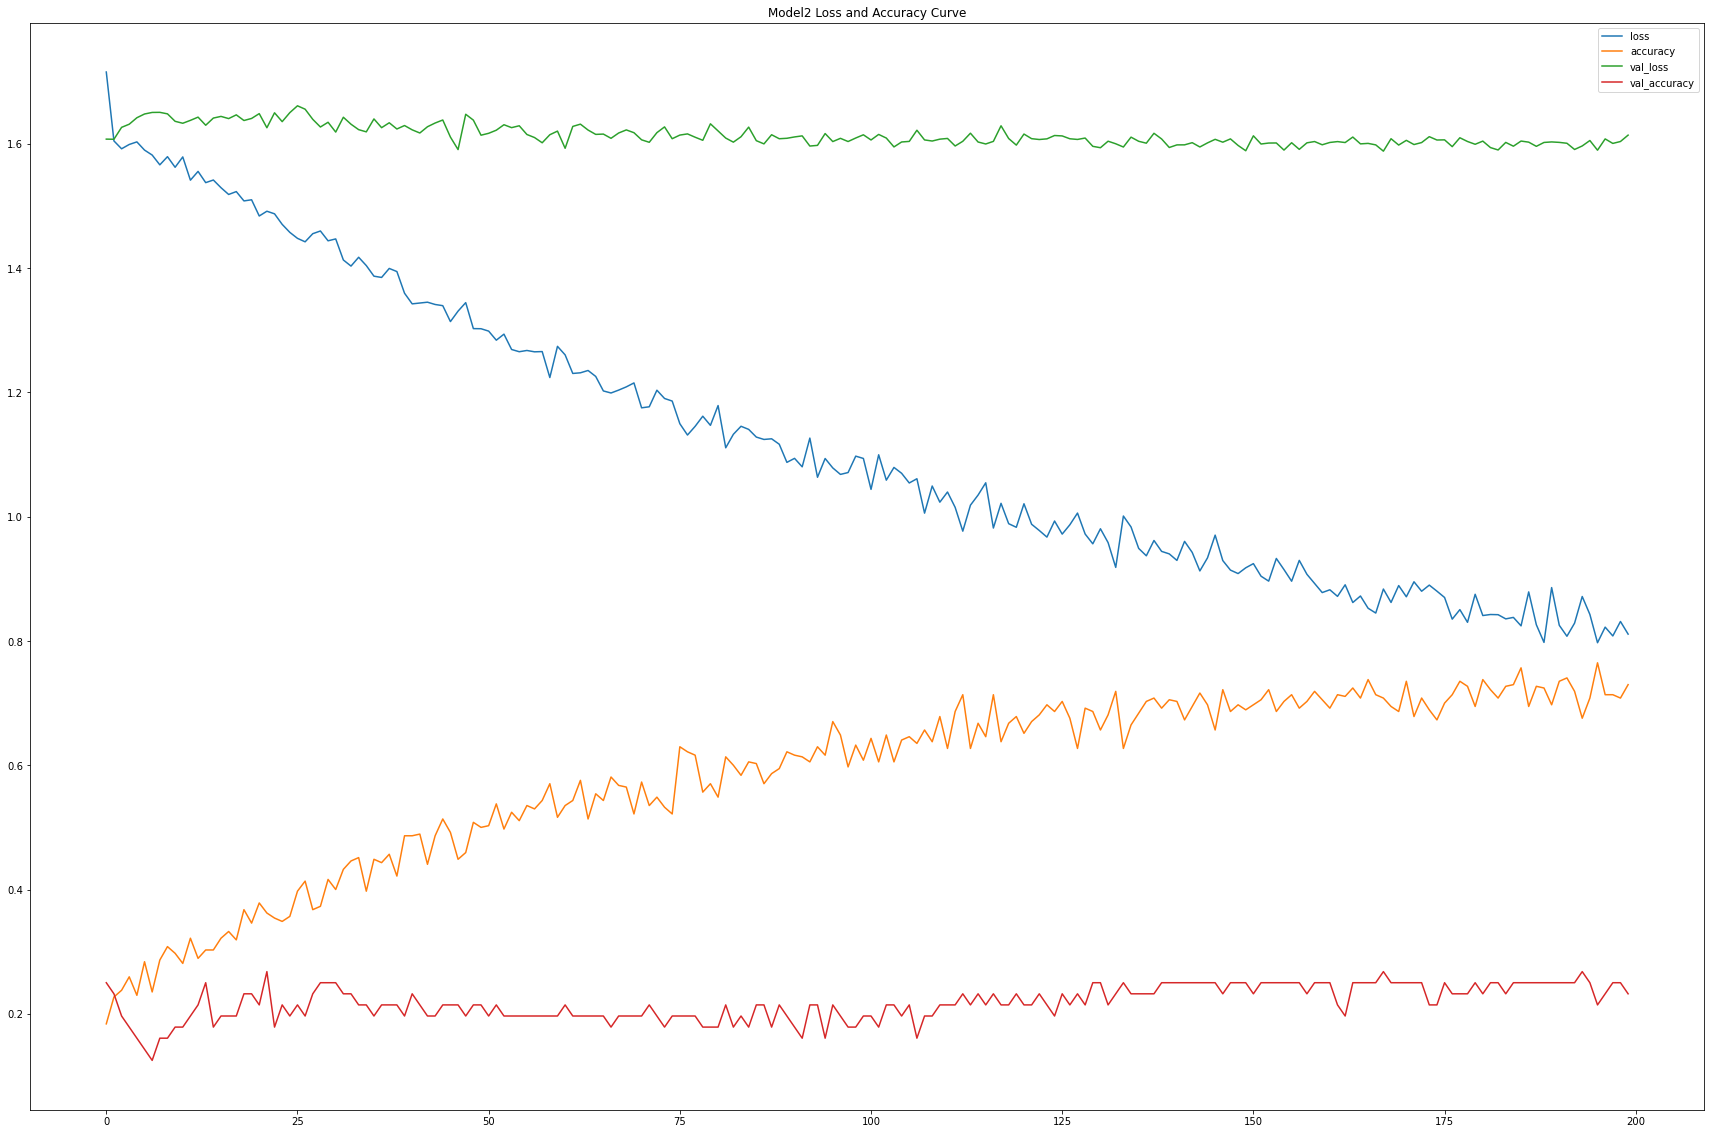

In [41]:
results2.plot(figsize=(30,20), title="Model2 Loss and Accuracy Curve")